# PharmGKB - Drug Label Annotations

URL: [https://www.pharmgkb.org/page/downloadLabelHelp](https://www.pharmgkb.org/page/downloadLabelHelp)

**Notes:**
* ...

In [14]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

import base64
import hashlib
import io
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import tarfile
import zipfile

from IPython.display import IFrame, HTML, JSON
from urllib.parse import urlparse, unquote
from tqdm.notebook import trange, tqdm

In [2]:
def sha256_checksum(file_path):
    sha256 = hashlib.sha256()
    with open(file_path, 'rb') as f:
        for chunk in iter(lambda: f.read(8192), b''):
            sha256.update(chunk)
    return sha256.hexdigest()

def barplot(df, column, title='', percentile=1.0):
    if title == '':
        title = column
    plt.figure(figsize=(11, 6))
    g = sns.barplot(df.groupby(df[column])[column].count().sort_values(ascending=False)[:np.int32(len(df)*percentile)].reset_index(name="count"), x=column, y='count')
    # Add labels above bars
    for container in g.containers:
        g.bar_label(container, fmt='%d', label_type='edge', padding=0)
    g.xaxis.set_major_locator(mticker.FixedLocator(g.get_xticks()))
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.title(title)
    plt.show()

In [3]:
urls = [
    'https://api.pharmgkb.org/v1/download/file/data/drugLabels.zip',
]

dfs = {}

for url in urls:
    filename = os.path.basename(unquote(urlparse(url).path))
    if not os.path.exists(filename):
        logging.info('Downloading: %s' % filename)   
        resp = requests.get(url)
        if resp.status_code == 200:
            with open(filename, 'wb') as f:
                f.write(resp.content)
            if os.path.isfile(filename):
                logging.info('rile downloaded successfully.')
            else:
                logging.error('file not downloaded')
        else:
            logging.error(f"Failed to download file. Status code: {resp.status_code}")
            logging.error('response: %s', resp.text)
    else:
        logging.info('file already exists: %s' % filename)
    if os.path.isfile(filename):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            for file_info in zip_ref.infolist():
                if file_info.filename.endswith('.tsv'):
                    with zip_ref.open(file_info.filename) as file:
                        df = pd.read_csv(file, sep='\t')
                        dfs[file_info.filename] = df
                        logging.info('file loaded: %s' % file_info.filename)                        

2025-07-01 06:22:05,565 - INFO - file already exists: drugLabels.zip
2025-07-01 06:22:05,583 - INFO - file loaded: drugLabels.tsv
2025-07-01 06:22:05,589 - INFO - file loaded: drugLabels.byGene.tsv


In [50]:
for filename, df in dfs.items():
    display(HTML(f'<h1>{filename}</h1>'))
    display(df)
    display(HTML(f'<br/><h2>statistics</h2>'))
    display(df.describe())
    display(HTML('<br/><hr/>'))

,PharmGKB ID,Name,Source,Biomarker Flag,Testing Level,Has Prescribing Info,Has Dosing Info,Has Alternate Drug,Has Other Prescribing Guidance,Cancer Genome,Prescribing,Chemicals,Genes,Variants/Haplotypes,Latest History Date (YYYY-MM-DD)
0,PA166269401,Annotation of EMA Label for nateglinide and CY...,EMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nateglinide,CYP2C9,NaN,2023-11-21
1,PA166269701,Annotation of EMA Label for glycerol phenylbut...,EMA,NaN,Testing Required,NaN,NaN,NaN,NaN,NaN,NaN,glycerol phenylbutyrate,ARG1; ASL; ASS1; CPS1; OTC,NaN,2024-08-07
2,PA166340141,Annotation of HCSC Label for amphetamine and C...,HCSC,NaN,Informative PGx,NaN,NaN,NaN,NaN,NaN,NaN,amphetamine,CYP2D6,NaN,2025-03-23
3,PA166273281,Annotation of EMA Label for nusinersen and SMN2,EMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nusinersen,SMN2,NaN,2023-08-17
4,PA166273261,Annotation of EMA Label for ospemifene and CYP...,EMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ospemifene,CYP2B6; CYP2C9,NaN,2024-12-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,PA166350741,Annotation of HCSC Label for aducanumab,HCSC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aducanumab,NaN,NaN,NaN
1299,PA166350722,Annotation of EMA Label for aducanumab,EMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aducanumab,NaN,NaN,NaN
1300,PA166350602,Annotation of EMA Label for patisiran and TTR,EMA,NaN,Testing Required,NaN,NaN,NaN,NaN,NaN,NaN,patisiran,TTR,NaN,NaN
1301,PA166351741,Annotation of FDA Label for phenytoin and CYP2C19,FDA,On FDA Biomarker List,Informative PGx,NaN,NaN,NaN,NaN,NaN,NaN,phenytoin,CYP2C19,NaN,2024-09-18


,PharmGKB ID,Name,Source,Biomarker Flag,Testing Level,Has Prescribing Info,Has Dosing Info,Has Alternate Drug,Has Other Prescribing Guidance,Cancer Genome,Prescribing,Chemicals,Genes,Variants/Haplotypes,Latest History Date (YYYY-MM-DD)
count,1303,1303,1303,471,896,270,86,116,99,342,270,1303,1147,203,854
unique,1303,1303,5,2,5,1,1,1,1,1,1,496,213,71,185
top,PA166114482,Annotation of EMA Label for vemurafenib and BRAF,FDA,On FDA Biomarker List,Testing Required,Prescribing Info,Dosing Info,Alternate Drug,Other Prescribing Guidance,Cancer Genome,Prescribing,lapatinib,CYP2D6,rs113488022,2023-02-28
freq,1,1,482,454,334,270,86,116,99,342,270,8,176,28,26


,Gene ID,Gene Symbol,Label IDs,Label Names
0,PA374,ABCB11,PA166353921;PA166269742;PA166353901;PA16626890...,Annotation of EMA Label for maralixibat and AB...
1,PA268,ABCB4,PA166353921;PA166353901,Annotation of EMA Label for maralixibat and AB...
2,PA390,ABCG2,PA166353201;PA166345301;PA166184427;PA166184499,Annotation of FDA Label for resmetirom and ABC...
3,PA24413,ABL1,PA166317521;PA166274001;PA166117941;PA16610491...,Annotation of EMA Label for asciminib and ABL1...
4,PA24428,ACADVL,PA166350521;PA166350541,Annotation of FDA Label for triheptanoin and A...
...,...,...,...,...
222,PA134919958,UNC13D,PA166182764,Annotation of FDA Label for emapalumab and PRF...
223,PA37307,VHL,PA166268881;PA166277981,Annotation of FDA Label for belzutifan and VHL...
224,PA133787052,VKORC1,PA166104776;PA166127732,Annotation of FDA Label for warfarin and CYP2C...
225,PA25361,XIAP,PA166182764,Annotation of FDA Label for emapalumab and PRF...


,Gene ID,Gene Symbol,Label IDs,Label Names
count,227,227,227,227
unique,227,227,160,160
top,PA37466,ZMPSTE24,PA166182742,Annotation of FDA Label for talazoparib and AT...
freq,1,1,10,10


In [13]:
genes = dfs['drugLabels.byGene.tsv']['Gene Symbol'].unique()
genes.sort()
genes

array(['ABCB11', 'ABCB4', 'ABCG2', 'ABL1', 'ACADVL', 'AGPAT2', 'AGXT',
       'AKR1D1', 'AKT1', 'ALDH5A1', 'ALK', 'AMACR', 'APC', 'APOB', 'APOE',
       'AQP4', 'ARG1', 'ASL', 'ASS1', 'ATM', 'ATP8B1', 'ATR', 'BCHE',
       'BCL2', 'BCL6', 'BCR', 'BLVRB', 'BRAF', 'BRCA1', 'BRCA2', 'BSCL2',
       'BTK', 'CACNA1S', 'CASR', 'CBL', 'CBS', 'CCR5', 'CD19', 'CD274',
       'CD33', 'CD38', 'CDK12', 'CDKL5', 'CFTR', 'CHEK2', 'CHRNA1',
       'CHRNA3', 'CHRNA4', 'CHRNA5', 'CHRNA6', 'CHRNA7', 'CHRNB1',
       'CHRNE', 'CPOX', 'CPS1', 'CPT2', 'CTNNB1', 'CXCR4', 'CYB5R1',
       'CYB5R2', 'CYB5R3', 'CYB5R4', 'CYP1A2', 'CYP27A1', 'CYP2A6',
       'CYP2B6', 'CYP2C19', 'CYP2C9', 'CYP2D6', 'CYP3A4', 'CYP3A5',
       'CYP7A1', 'DHCR7', 'DMD', 'DPYD', 'EGFR', 'ERBB2', 'ESR1', 'ESR2',
       'F2', 'F5', 'F8', 'FANCA', 'FCGR2A', 'FCGR2B', 'FCGR3A', 'FGFR1',
       'FGFR2', 'FGFR3', 'FIP1L1', 'FLT3', 'FOLH1', 'FOLR1', 'G6PD',
       'GAA', 'GALNS', 'GBA1', 'GH1', 'GHR', 'GLA', 'HADHA', 'HADHB',
       'HBB'

In [7]:
df_genes = pd.DataFrame(dfs['drugLabels.tsv']['Genes']).apply(lambda x: x.str.split(";")).explode('Genes')
df_genes.reset_index(drop=True, inplace=True)
df_genes

,Genes
0,CYP2C9
1,ARG1
2,ASL
3,ASS1
4,CPS1
...,...
1998,NaN
1999,NaN
2000,TTR
2001,CYP2C19


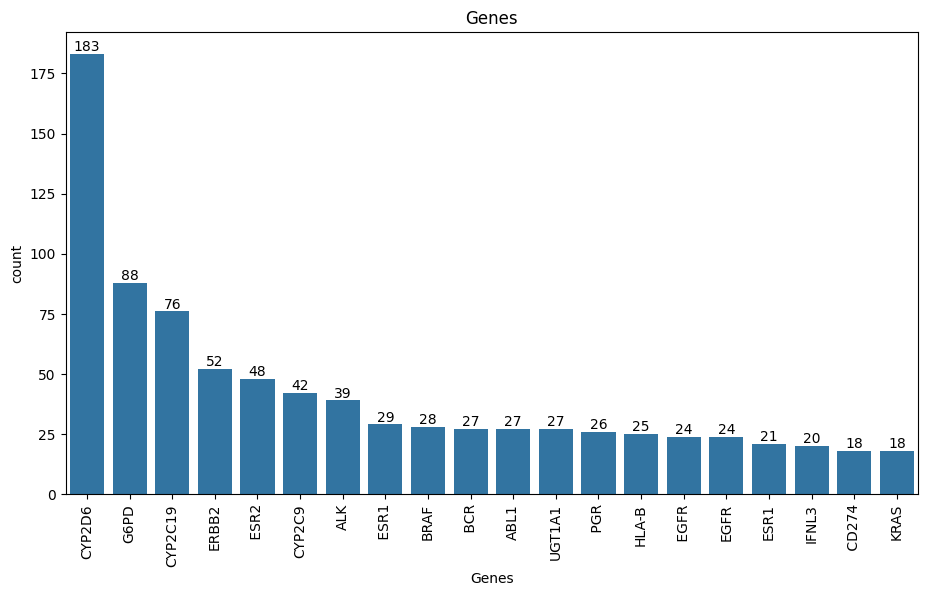

In [9]:
barplot(df_genes, 'Genes', percentile=1/100)

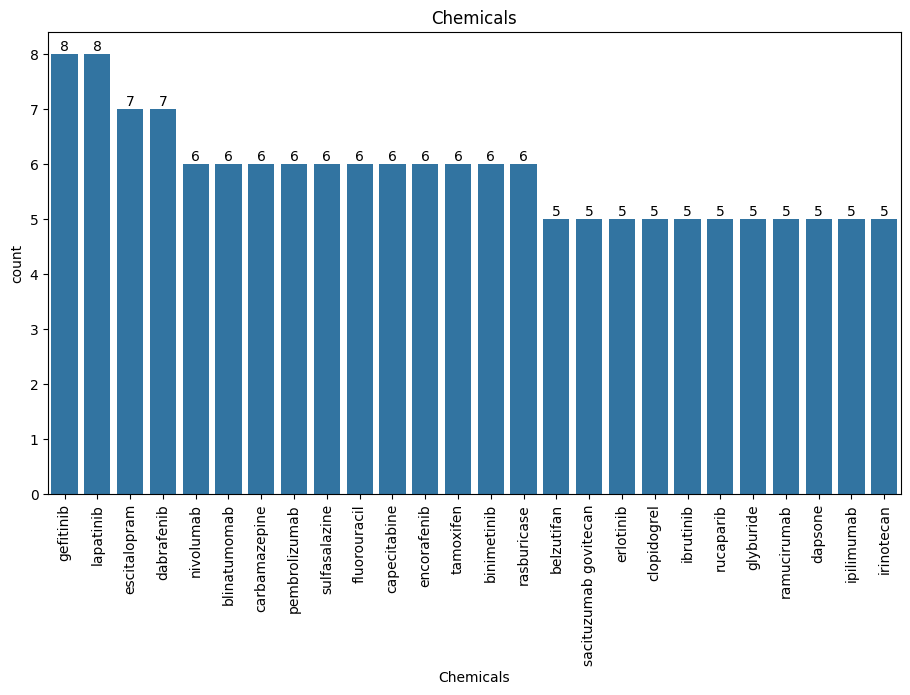

In [53]:
barplot(dfs['drugLabels.tsv'], 'Chemicals', percentile=1/50)

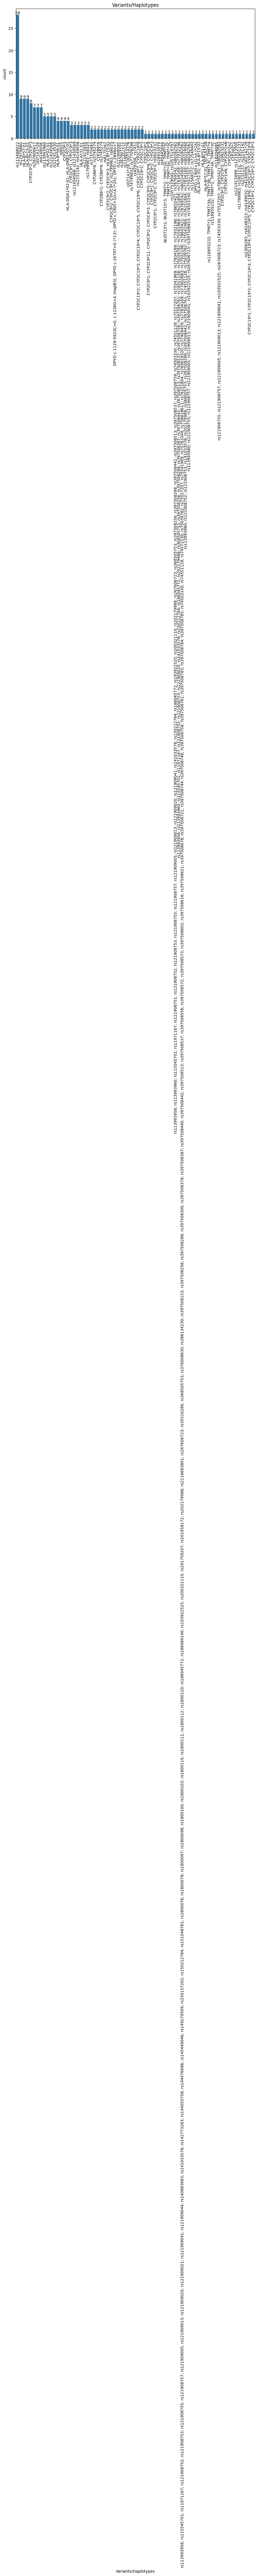

In [54]:
barplot(dfs['drugLabels.tsv'], 'Variants/Haplotypes')